In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [14]:
time0 = time.time()
#导入数据
data = pd.read_excel(r"F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\空气补气速度.xlsx")
# 分离特征值和结果值
data_x = np.array(data.iloc[:,0:4])
data_y =np.array(data.iloc[:,4:5]) 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=42)
# 特征缩放
scaler = StandardScaler() #创建一个scaler的示例函数
X_train = scaler.fit_transform(X_train) #将训练特征转化为零均值、单位方差
X_test = scaler.transform(X_test)#将测试特征转化为零均值、单位方差
# 将numpy数组转换为torch张量 提供pytorch的运算格式
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

In [1]:
# 定义PyTorch中的人工神经网络模型
class ANNModel(nn.Module): #定义人工神经网络的类，继承nn.module父类
    def __init__(self, num_features, hidden_layers=[50], activation_fn=nn.ReLU):# 创建构造函数，以便接收输入特征数量、隐藏层个数和神经元数量、激活函数的类型
        super(ANNModel, self).__init__() #调用基类nn。moudle的构造函数
        layers = [] #创建一个空列表，存储神经网络中的层
        input_features = num_features #输入层特征数量
        for output_features in hidden_layers: #遍历隐藏层
            layers.append(nn.Linear(input_features, output_features))# 添加一个线性层，这个线性层接收输入特征输入，并输出output_features的输出
            layers.append(activation_fn())# 添加激活函数
            input_features = output_features # 迭代更新，在一个隐藏层之后，下一层的输入特征数将等于当前层的输出特征数
        layers.append(nn.Linear(input_features, 1))  # 在循环结束后，添加一个输出层。这个输出层将最后一个隐藏层的输出转换为单个值。
        self.layers = nn.Sequential(*layers) #nn.Sequential是一个特殊的模块，可以容纳其他模块，并按顺序应用这些模块
        
    def forward(self, X): # 定义了前向传播函数。这是nn.Module要求你重载的一个方法。当输入数据X传递到模型时，这个方法会被调用。
        return self.layers(X) #调用之前定义的self.layers并向其传递输入X，执行前向传播，并返回网络的输出。这就是模型预测的值。

# 使用skorch包装PyTorch模型以适应scikit-learn接口
#scikit-learn 是一个流行的机器学习库，此处用来进行参数搜索和交叉验证。
net = NeuralNetRegressor(
    module=ANNModel,
    module__num_features=X_train.shape[1],
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=32,
    max_epochs=20,
    verbose=0,
    device='gpu'#使用GPU cuda
)

# 定义超参数选择模型，通过K折交叉得到最好的超参数组合
param_grid = {
    'module__num_features': [X_train.shape[1]],  # 假设X_train是你的特征数据
    'module__hidden_layers': [[50], [100], [50, 30], [100, 50],[50,50,50],[100,100,100]],  # 不同的层配置
    'module__activation_fn': [nn.ReLU, nn.Tanh],  # 不同的激活函数
    'lr': [0.01, 0.001,0.1,1],  # 学习率
    'max_epochs': [10, 20,30,40,50,60,70,80,90,100,200,300,400],  # 训练周期数
}

# 使用GridSearchCV搜索超参数
gs = GridSearchCV(net, param_grid, refit=True, cv=3, scoring='neg_mean_squared_error') #进行超参数选择，选择之变为负均方根误差，
gs.fit(X_train_tensor.numpy(), y_train_tensor.numpy()) #使用不同参数进行训练

print("最佳参数: ", gs.best_params_)
print("最佳分数（负均方根误差）: ", gs.best_score_)

# 使用最佳参数训练模型
model = gs.best_estimator_ #调用K折交叉检验方法best_estimator方法，使用最高的参数组合作为人工神经网络的训练模型

# 预测和评估
y_test_pred = model.predict(X_test_tensor.numpy()) # 使用最佳训练模型来预测空气补充速度
mse = mean_squared_error(y_test_tensor.numpy(), y_test_pred) #调用mean_squared_error函数用来计算测试集的均方根误差
print("均方根误差（MSE）: ", mse)
r2_test = r2_score(y_test_tensor.numpy(), y_test_pred)#调用r2_score函数用来计算测试集的确定系数
print("测试集R平方值: ", r2_test)
y_train_pred = model.predict(X_train_tensor.numpy())
r2_train = r2_score(y_train_tensor.numpy(), y_train_pred)#调用r2_score函数用来计算预测集的确定系数
print("训练集R平方值: ", r2_train)

# 对测试集进行MAE计算
mae_test = mean_absolute_error(y_test, y_test_pred)#调用mean_absolute_error函数用来计算预测集的平均绝对误差
print("测试集MAE: ", mae_test)
# 对训练集进行MAE计算
mae_train = mean_absolute_error(y_train, y_train_pred)#调用mean_absolute_error函数用来计算训练集的平均绝对误差
print("训练集MAE: ", mae_train)

time1 = time.time() # 计算训练所需要的时间
print("训练时间: ", time1-time0)

最佳参数:  {'lr': 0.1, 'max_epochs': 300, 'module__activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'module__hidden_layers': [50], 'module__num_features': 4}
最佳分数（负均方误差）:  -0.009767874454458555
均方根误差（MSE）:  0.019430557
测试集R平方值:  0.9734954181270888
训练集R平方值:  0.9793831884060518
训练时间:  3197.473084449768


In [18]:
# 使用最佳参数训练模型
model = gs.best_estimator_
# 预测和评估
y_test_pred = model.predict(X_test_tensor.numpy())
mse = mean_squared_error(y_test_tensor.numpy(), y_test_pred)
print("均方根误差（MSE）: ", mse)
r2_test = r2_score(y_test_tensor.numpy(), y_test_pred)
print("测试集R平方值: ", r2_test)
y_train_pred = model.predict(X_train_tensor.numpy())
r2_train = r2_score(y_train_tensor.numpy(), y_train_pred)
print("训练集R平方值: ", r2_train)
time1 = time.time()
print("训练时间: ", time1-time0)
print("测试集MAE: ", mae_test)
# 对训练集进行MAE计算
mae_train = mean_absolute_error(y_train, y_train_pred)
print("训练集MAE: ", mae_train)


均方根误差（MSE）:  0.019430557
测试集R平方值:  0.9734954181270888
训练集R平方值:  0.9793831884060518
训练时间:  129.46126461029053
测试集MAE:  0.6336764031763785
训练集MAE:  0.09075731596643208


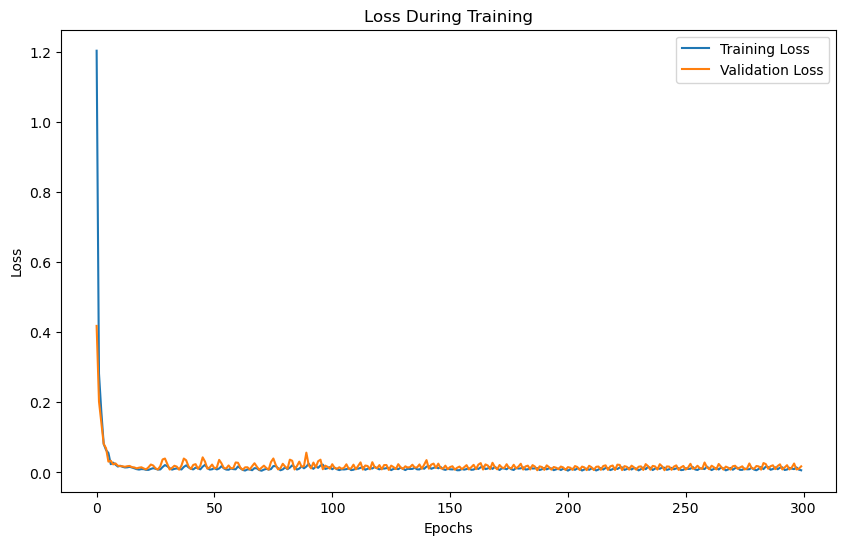

In [19]:
#绘制得到损失值与迭代步数之间的关系图
history = model.history
train_losses = [epoch['train_loss'] for epoch in history]
valid_losses = [epoch['valid_loss'] for epoch in history if 'valid_loss' in epoch]  # 如果进行了验证
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
if valid_losses:  # 如果有验证损失
    plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

In [22]:
# 训练数据和模型训练集数据进行保存
y_train_data = pd.DataFrame(y_train)
y_train_data = y_train_data.reset_index()
y_train_pred_data = pd.DataFrame(y_train_pred)
y_train_pred_data = y_train_pred_data.reset_index()
train_data = pd.concat([y_train_data,y_train_pred_data],axis=1,ignore_index=True)
train_data_base = train_data[[1,3]].to_csv(r'F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\3-不同机器学习模型下预测效果的判定\ANN\ANN_train.csv')

In [23]:
# 测试数据和模型测试集数据进行保存
y_test_data = pd.DataFrame(y_test)
y_test_data = y_test_data.reset_index()
y_test_pred_data = pd.DataFrame(y_test_pred)
y_test_pred_data = y_test_pred_data.reset_index()
test_data = pd.concat([y_test_data,y_test_pred_data],axis=1,ignore_index=True)
test_data_base = test_data[[1,3]].to_csv(r'F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\3-不同机器学习模型下预测效果的判定\ANN\ANN_test.csv')

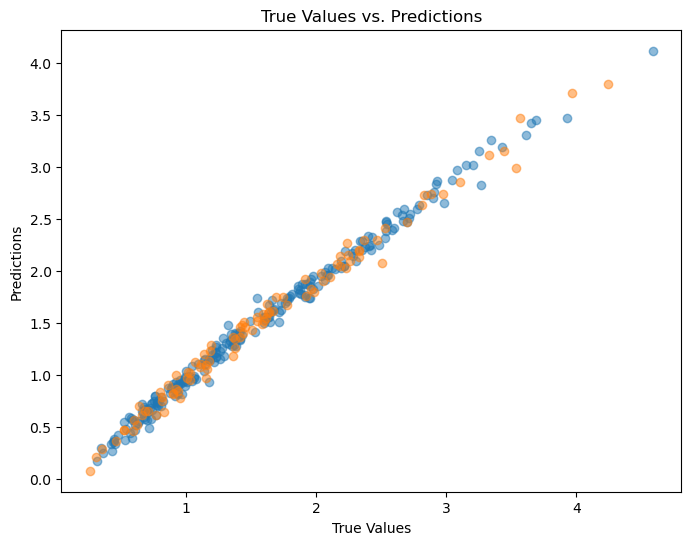

In [20]:
# 对数据进行相应的可视化操作
plt.figure(figsize=(8, 6))  # 设置图形大小
# 绘制散点图

plt.scatter(y_train, y_train_pred, alpha=0.5)  
plt.scatter(y_test, y_test_pred, alpha=0.5)  
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')

# 绘制一条对角线，表示理想情况下预测值等于真实值
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

# 显示图形
plt.show()